In [73]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from tensorflow.keras.callbacks import EarlyStopping
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from matplotlib import pyplot as plt
import random
from osgeo import gdal
import imageio

In [2]:
# converts any image with more than 3 channels to a 3 channel image
def convert_to_rgb(filename):
    # Open the original image using GDAL
    src_ds = gdal.Open(filename)
    # Read the georeferencing information
    geotransform = src_ds.GetGeoTransform()
    projection = src_ds.GetProjection()

    # Convert the image to RGB using PIL
    image = imageio.imread(filename)

    # Convert the image to RGB
    image = image[..., :3]

    # Save the image as a TIFF file
    imageio.imwrite(filename, image)

    # Open the converted image using GDAL
    dst_ds = gdal.Open(filename, gdal.GA_Update)

    # Write the georeferencing information to the converted image
    dst_ds.SetGeoTransform(geotransform)
    dst_ds.SetProjection(projection)

    # Close the datasets
    src_ds = None
    dst_ds = None

In [ ]:
directory = '/path/to/training_images'
for filename in os.listdir(directory):
    convert_to_rgb(filename)

In [ ]:
patches_img = []
directory = '/path/to/training_images'
for filename in os.listdir(directory):
    large_image_stack = tiff.imread(filename)
    patch = patchify(large_image_stack, (256, 256,3), step=256)
    patches_img+patch

In [ ]:
patches_masks = []
directory = '/path/to/training_masks'
for filename in os.listdir(directory):
    large_mask_stack = tiff.imread(filename)
    large_mask_stack = np.array(large_mask_stack)
    large_mask_stack = np.where(large_mask_stack >= 1, 1, large_mask_stack)
    patch = patchify(large_image_stack, (256, 256,3), step=256)
    patches_masks+patch

In [95]:
all_mask_patches = []
for i in range(patches_masks.shape[0]):
    for j in range(patches_masks.shape[1]):
        single_patch_image = patches_masks[i,j,:,:]
        all_mask_patches.append(single_patch_image)

In [96]:
all_images_patches = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_mask = patches_img[i,j,:,:]
        min_val = single_patch_mask.min()
        max_val = single_patch_mask.max()
        single_patch_mask = (single_patch_mask - min_val) / (max_val - min_val)
        single_patch_mask = single_patch_mask.astype('float32')
        single_patch_mask = single_patch_mask[0]
        all_images_patches.append(single_patch_mask)

In [97]:
image_dataset = np.array(all_images_patches)

In [98]:
mask_dataset = np.array(all_mask_patches)
masks_dataset = np.expand_dims(mask_dataset, -1)

In [ ]:
random_image_id = random.randint(0, 702)

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [17]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [18]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

In [19]:
images1=preprocess_input1(image_dataset)
print(images1.shape)

(702, 256, 256, 3)


In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images1, mask_dataset, test_size = 0.25, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(526, 256, 256, 3)
(176, 256, 256, 3)


In [21]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_1[0][0]']                  
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 D)                             64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_3[0][0]']                  
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_4[0][0]']                  
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 2D)                            128)                                                              
          

 add_7 (Add)                    (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_7[0][0]']                  
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 2D)      

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_10[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_24 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_13[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_30 (ZeroPadding  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 2D)                            512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [22]:
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

history = model.fit(X_train, y_train,
                    batch_size=16,
                    verbose=1,
                    epochs=70,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/3


2023-07-29 10:59:54.132839: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


33/33 [==============================] - 164s 5s/step - loss: 1.2048 - iou_score: 0.0892 - val_loss: 1.8339 - val_iou_score: 0.0419
Epoch 2/3
33/33 [==============================] - 382s 12s/step - loss: 1.0358 - iou_score: 0.1654 - val_loss: 15.1085 - val_iou_score: 0.0598
Epoch 3/3
33/33 [==============================] - 177s 5s/step - loss: 0.9461 - iou_score: 0.2262 - val_loss: 1.4041 - val_iou_score: 0.0522


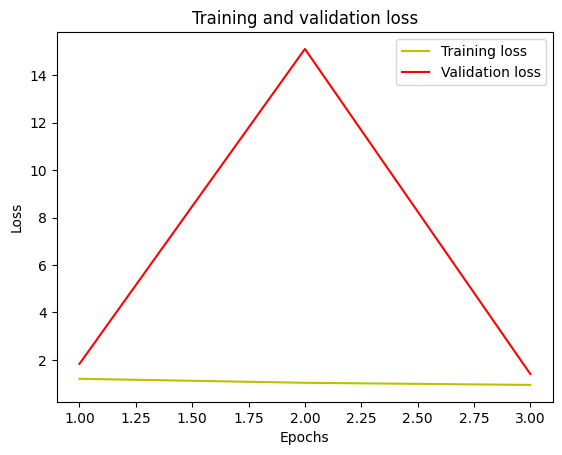

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

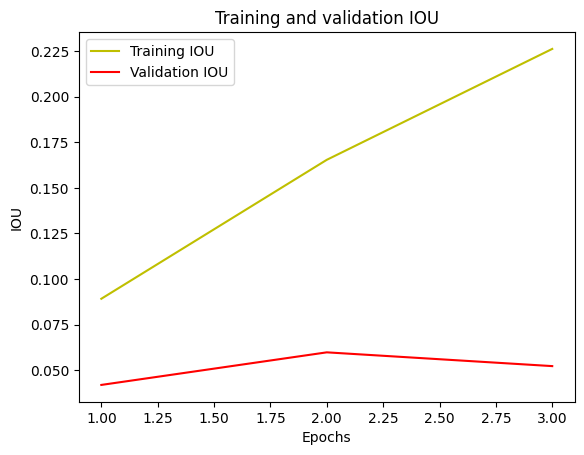

In [26]:
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [28]:
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

# Remove the extra dimension from y_pred_thresholded
y_pred_thresholded = np.squeeze(y_pred_thresholded)

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

6/6 [==============================] - 10s 2s/step


In [79]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]
prediction = (prediction >= 0.5).astype(float)

1/1 [==============================] - 1s 725ms/step


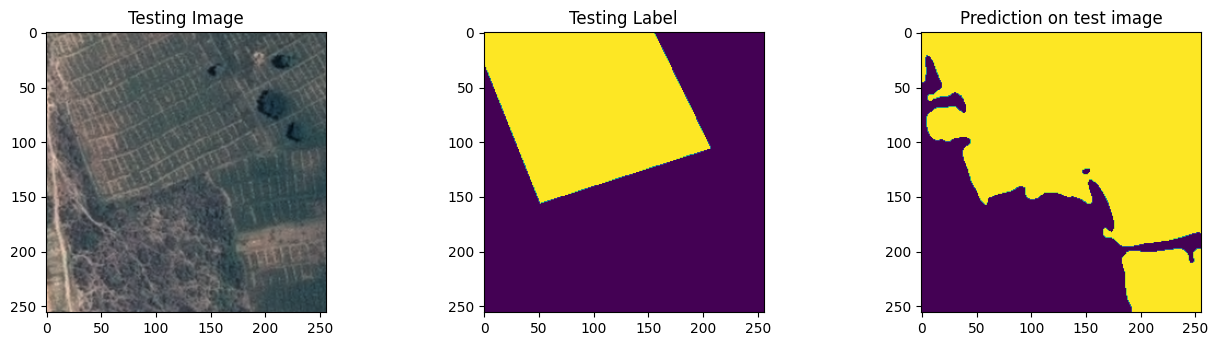

In [80]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction)
plt.show()


In [100]:
true_classes = y_test[:]
predicted_classes = []

for i in range(0,len(true_classes)):
    test_img = X_test[i]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = model.predict(test_img_input)
    prediction = prediction[0,:,:,0]
    prediction = (prediction >= 0.5).astype(float)
    predicted_classes.append(prediction)
    

1/1 [==============================] - 0s 80ms/step


In [101]:
accuracies = []
precisions = []
recalls = []
f1s = []
for true, pred in zip(true_classes, predicted_classes):
    accuracies.append(metrics.accuracy_score(true, pred))
    precisions.append(metrics.precision_score(true, pred,average= 'micro'))
    recalls.append(metrics.recall_score(true, pred,average='micro'))
    f1s.append(metrics.f1_score(true, pred,average='micro'))
    
accuracy = np.mean(accuracies)
precision = np.mean(precisions)
recall = np.mean(recalls)
f1 = np.mean(f1s)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/macbookair/anaconda3/envs/ML/

/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/skl

/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/macbookair/anaconda3/envs/ML/

/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/macbookair/anaconda3/envs/ML/

/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/macbookair/anaconda3/envs/ML/

/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/macbookair/anaconda3/envs/ML/

/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/macbookair/anaconda3/envs/ML/

Accuracy: 0.659912109375
Precision: 0.4296939287124511
Recall: 0.38680812360563266
F1 Score: 0.3983157918882169


/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookair/anaconda3/envs/ML/

In [72]:
model.save('segment_anything_model.h5')